## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.regularizers import l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [15]:
import itertools
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Epoch 12/50
50000/50000 [==============================] - 27s 546us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 28s 555us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 28s 561us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 17/50
50000/50000 [==============================] - 28s 559us/step - loss: 2.4626 - acc: 0.0971 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 18/50
50000/50000 [==============================] - 28s 551us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 19/50
50000/50000 [==============================] - 28s 551us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 20/50
50000/50000 [==============================] - 28s 557us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 21/50
50000/50

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 34s 680us/step - loss: 199.0090 - acc: 0.2229 - val_loss: 41.2640 - val_acc: 0.2472
Epoch 2/50
50000/50000 [==============================] - 27s 544us/step - loss: 19.1976 - acc: 0.1141 - val_loss: 7.3221 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 27s 539us/step - loss: 4.1249 - acc: 0.0992 - val_loss: 2.6485 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 27s 534us/step - loss: 2.4860 - acc: 0.0988 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 28s 558us/step - loss: 2.4626 - acc: 0.0965 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 28s 559us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 20s 392us/step - loss: 2.4626 - acc: 0.0971 - val_loss

50000/50000 [==============================] - 18s 366us/step - loss: 2.4626 - acc: 0.0955 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 38/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.1000 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 39/50
50000/50000 [==============================] - 19s 372us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 40/50
50000/50000 [==============================] - 18s 360us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 41/50
50000/50000 [==============================] - 18s 366us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 19s 371us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 18s 365us/step - loss: 2.4626 - acc: 0.0992 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 49/50
50000/50000 [=======

_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 461us/step - loss: 5.9776 - acc: 0.2853 - val_loss: 5.7963 - val_acc: 0.3457
Epoch 2/50
50000/50000 [==============================] - 19s 388us/step - loss: 5.7093 - acc: 0.3686 - val_loss: 5.6343 - val_acc: 0.3842
Ep

50000/50000 [==============================] - 13s 267us/step - loss: 5.1456 - acc: 0.4550 - val_loss: 5.1252 - val_acc: 0.4454
Epoch 8/50
50000/50000 [==============================] - 13s 263us/step - loss: 5.0534 - acc: 0.4666 - val_loss: 5.0335 - val_acc: 0.4587
Epoch 9/50
50000/50000 [==============================] - 13s 267us/step - loss: 4.9645 - acc: 0.4777 - val_loss: 4.9442 - val_acc: 0.4647
Epoch 10/50
50000/50000 [==============================] - 13s 266us/step - loss: 4.8795 - acc: 0.4844 - val_loss: 4.8823 - val_acc: 0.4660
Epoch 11/50
50000/50000 [==============================] - 13s 269us/step - loss: 4.7981 - acc: 0.4909 - val_loss: 4.7955 - val_acc: 0.4739
Epoch 12/50
50000/50000 [==============================] - 13s 266us/step - loss: 4.7166 - acc: 0.5005 - val_loss: 4.7298 - val_acc: 0.4758
Epoch 13/50
50000/50000 [==============================] - 13s 265us/step - loss: 4.6390 - acc: 0.5061 - val_loss: 4.6625 - val_acc: 0.4809
Epoch 14/50
50000/50000 [=========

Epoch 8/50
50000/50000 [==============================] - 12s 248us/step - loss: 5.0505 - acc: 0.4678 - val_loss: 5.0261 - val_acc: 0.4662
Epoch 9/50
50000/50000 [==============================] - 12s 248us/step - loss: 4.9636 - acc: 0.4791 - val_loss: 4.9602 - val_acc: 0.4687
Epoch 10/50
50000/50000 [==============================] - 12s 249us/step - loss: 4.8817 - acc: 0.4851 - val_loss: 4.8659 - val_acc: 0.4731
Epoch 11/50
50000/50000 [==============================] - 12s 249us/step - loss: 4.7979 - acc: 0.4943 - val_loss: 4.7967 - val_acc: 0.4822
Epoch 12/50
50000/50000 [==============================] - 12s 244us/step - loss: 4.7195 - acc: 0.5011 - val_loss: 4.7384 - val_acc: 0.4762
Epoch 13/50
50000/50000 [==============================] - 12s 250us/step - loss: 4.6428 - acc: 0.5072 - val_loss: 4.6677 - val_acc: 0.4772
Epoch 14/50
50000/50000 [==============================] - 12s 244us/step - loss: 4.5655 - acc: 0.5148 - val_loss: 4.5882 - val_acc: 0.4899
Epoch 15/50
50000/5000

Epoch 9/50
50000/50000 [==============================] - 13s 266us/step - loss: 5.4538 - acc: 0.4291 - val_loss: 5.1724 - val_acc: 0.4253
Epoch 10/50
50000/50000 [==============================] - 13s 264us/step - loss: 4.9090 - acc: 0.4384 - val_loss: 4.6695 - val_acc: 0.4323
Epoch 11/50
50000/50000 [==============================] - 13s 259us/step - loss: 4.4461 - acc: 0.4406 - val_loss: 4.2477 - val_acc: 0.4346
Epoch 12/50
50000/50000 [==============================] - 13s 267us/step - loss: 4.0494 - acc: 0.4459 - val_loss: 3.8747 - val_acc: 0.4440
Epoch 13/50
50000/50000 [==============================] - 13s 269us/step - loss: 3.7087 - acc: 0.4485 - val_loss: 3.5716 - val_acc: 0.4397
Epoch 14/50
50000/50000 [==============================] - 13s 264us/step - loss: 3.4180 - acc: 0.4534 - val_loss: 3.2987 - val_acc: 0.4431
Epoch 15/50
50000/50000 [==============================] - 13s 268us/step - loss: 3.1689 - acc: 0.4552 - val_loss: 3.0649 - val_acc: 0.4534
Epoch 16/50
50000/500

Epoch 10/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.5970 - acc: 0.4879 - val_loss: 1.6571 - val_acc: 0.4651
Epoch 11/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.5740 - acc: 0.4967 - val_loss: 1.6020 - val_acc: 0.4817
Epoch 12/50
50000/50000 [==============================] - 13s 265us/step - loss: 1.5491 - acc: 0.5043 - val_loss: 1.5849 - val_acc: 0.4864
Epoch 13/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.5283 - acc: 0.5120 - val_loss: 1.5805 - val_acc: 0.4892
Epoch 14/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.5089 - acc: 0.5174 - val_loss: 1.5727 - val_acc: 0.4866
Epoch 15/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.4899 - acc: 0.5239 - val_loss: 1.5559 - val_acc: 0.4932
Epoch 16/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.4705 - acc: 0.5319 - val_loss: 1.5532 - val_acc: 0.4949
Epoch 17/50
50000/50

50000/50000 [==============================] - 14s 277us/step - loss: 1.4434 - acc: 0.4961 - val_loss: 1.4871 - val_acc: 0.4734
Epoch 11/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.4196 - acc: 0.5030 - val_loss: 1.4645 - val_acc: 0.4826
Epoch 12/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.3945 - acc: 0.5135 - val_loss: 1.4514 - val_acc: 0.4838
Epoch 13/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.3726 - acc: 0.5200 - val_loss: 1.4361 - val_acc: 0.4851
Epoch 14/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.3560 - acc: 0.5241 - val_loss: 1.4282 - val_acc: 0.4933
Epoch 15/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.3311 - acc: 0.5367 - val_loss: 1.4102 - val_acc: 0.4969
Epoch 16/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.3173 - acc: 0.5391 - val_loss: 1.4010 - val_acc: 0.5014
Epoch 17/50
50000/50000 [=======

Epoch 11/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.4424 - acc: 0.4930 - val_loss: 1.4738 - val_acc: 0.4755
Epoch 12/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.4200 - acc: 0.4992 - val_loss: 1.4611 - val_acc: 0.4831
Epoch 13/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.3983 - acc: 0.5089 - val_loss: 1.4517 - val_acc: 0.4825
Epoch 14/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.3776 - acc: 0.5167 - val_loss: 1.4329 - val_acc: 0.4883
Epoch 15/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.3598 - acc: 0.5209 - val_loss: 1.4275 - val_acc: 0.4939
Epoch 16/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.3409 - acc: 0.5286 - val_loss: 1.4375 - val_acc: 0.4933
Epoch 17/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.3254 - acc: 0.5360 - val_loss: 1.4008 - val_acc: 0.4998
Epoch 18/50
50000/50

Epoch 12/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.4067 - acc: 0.5079 - val_loss: 1.4582 - val_acc: 0.4823
Epoch 13/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.3857 - acc: 0.5142 - val_loss: 1.4476 - val_acc: 0.4863
Epoch 14/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.3654 - acc: 0.5200 - val_loss: 1.4286 - val_acc: 0.4893
Epoch 15/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.3449 - acc: 0.5288 - val_loss: 1.4178 - val_acc: 0.4991
Epoch 16/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.3279 - acc: 0.5345 - val_loss: 1.4081 - val_acc: 0.5042
Epoch 17/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.3094 - acc: 0.5416 - val_loss: 1.3989 - val_acc: 0.5050
Epoch 18/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.2915 - acc: 0.5474 - val_loss: 1.4069 - val_acc: 0.5034
Epoch 19/50
50000/50

Epoch 13/50
50000/50000 [==============================] - 13s 262us/step - loss: 3.7025 - acc: 0.4538 - val_loss: 3.5548 - val_acc: 0.4513
Epoch 14/50
50000/50000 [==============================] - 13s 264us/step - loss: 3.4113 - acc: 0.4568 - val_loss: 3.2865 - val_acc: 0.4549
Epoch 15/50
50000/50000 [==============================] - 13s 264us/step - loss: 3.1609 - acc: 0.4606 - val_loss: 3.0616 - val_acc: 0.4598
Epoch 16/50
50000/50000 [==============================] - 13s 264us/step - loss: 2.9486 - acc: 0.4636 - val_loss: 2.8738 - val_acc: 0.4495
Epoch 17/50
50000/50000 [==============================] - 13s 266us/step - loss: 2.7650 - acc: 0.4662 - val_loss: 2.7020 - val_acc: 0.4609
Epoch 18/50
50000/50000 [==============================] - 13s 262us/step - loss: 2.6082 - acc: 0.4692 - val_loss: 2.5529 - val_acc: 0.4619
Epoch 19/50
50000/50000 [==============================] - 13s 264us/step - loss: 2.4737 - acc: 0.4711 - val_loss: 2.4269 - val_acc: 0.4728
Epoch 20/50
50000/50

Epoch 14/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.5116 - acc: 0.5169 - val_loss: 1.5565 - val_acc: 0.4968
Epoch 15/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.4927 - acc: 0.5255 - val_loss: 1.5771 - val_acc: 0.4917
Epoch 16/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.4740 - acc: 0.5322 - val_loss: 1.5454 - val_acc: 0.5010
Epoch 17/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.4570 - acc: 0.5374 - val_loss: 1.5464 - val_acc: 0.5052
Epoch 18/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.4400 - acc: 0.5435 - val_loss: 1.5723 - val_acc: 0.4915
Epoch 19/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.4223 - acc: 0.5498 - val_loss: 1.5338 - val_acc: 0.5016
Epoch 20/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.4094 - acc: 0.5524 - val_loss: 1.5352 - val_acc: 0.5013
Epoch 21/50
50000/50

Epoch 15/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3537 - acc: 0.5242 - val_loss: 1.4170 - val_acc: 0.4990
Epoch 16/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3328 - acc: 0.5340 - val_loss: 1.4168 - val_acc: 0.5081
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3162 - acc: 0.5373 - val_loss: 1.4030 - val_acc: 0.5068
Epoch 18/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2992 - acc: 0.5440 - val_loss: 1.4216 - val_acc: 0.4862
Epoch 19/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2814 - acc: 0.5505 - val_loss: 1.3878 - val_acc: 0.5066
Epoch 20/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.2664 - acc: 0.5567 - val_loss: 1.3863 - val_acc: 0.5105
Epoch 21/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2491 - acc: 0.5630 - val_loss: 1.3689 - val_acc: 0.5169
Epoch 22/50
50000/50000 [==

50000/50000 [==============================] - 8s 163us/step - loss: 1.3328 - acc: 0.5337 - val_loss: 1.4163 - val_acc: 0.4961
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3158 - acc: 0.5392 - val_loss: 1.3924 - val_acc: 0.5012
Epoch 18/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.2996 - acc: 0.5443 - val_loss: 1.3965 - val_acc: 0.5017
Epoch 19/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2843 - acc: 0.5516 - val_loss: 1.3818 - val_acc: 0.5078
Epoch 20/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2664 - acc: 0.5575 - val_loss: 1.3989 - val_acc: 0.5056
Epoch 21/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2505 - acc: 0.5632 - val_loss: 1.3687 - val_acc: 0.5130
Epoch 22/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.2388 - acc: 0.5665 - val_loss: 1.3819 - val_acc: 0.5099
Epoch 23/50
50000/50000 [==============

50000/50000 [==============================] - 7s 145us/step - loss: 1.3205 - acc: 0.5365 - val_loss: 1.3947 - val_acc: 0.5051
Epoch 18/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.3039 - acc: 0.5414 - val_loss: 1.3954 - val_acc: 0.5025
Epoch 19/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2894 - acc: 0.5469 - val_loss: 1.4186 - val_acc: 0.5003
Epoch 20/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.2705 - acc: 0.5503 - val_loss: 1.3912 - val_acc: 0.5039
Epoch 21/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.2549 - acc: 0.5593 - val_loss: 1.3883 - val_acc: 0.5077
Epoch 22/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.2396 - acc: 0.5648 - val_loss: 1.3761 - val_acc: 0.5085
Epoch 23/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2230 - acc: 0.5704 - val_loss: 1.3765 - val_acc: 0.5143
Epoch 24/50
50000/50000 [==============

50000/50000 [==============================] - 7s 144us/step - loss: 2.6124 - acc: 0.4654 - val_loss: 2.5577 - val_acc: 0.4547
Epoch 19/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4775 - acc: 0.4667 - val_loss: 2.4508 - val_acc: 0.4500
Epoch 20/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.3616 - acc: 0.4711 - val_loss: 2.3221 - val_acc: 0.4638
Epoch 21/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.2631 - acc: 0.4747 - val_loss: 2.2500 - val_acc: 0.4569
Epoch 22/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.1771 - acc: 0.4756 - val_loss: 2.1571 - val_acc: 0.4663
Epoch 23/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.1047 - acc: 0.4768 - val_loss: 2.1075 - val_acc: 0.4583
Epoch 24/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.0402 - acc: 0.4802 - val_loss: 2.0303 - val_acc: 0.4737
Epoch 25/50
50000/50000 [==============

50000/50000 [==============================] - 7s 144us/step - loss: 1.4089 - acc: 0.5514 - val_loss: 1.5265 - val_acc: 0.5000
Epoch 20/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.3959 - acc: 0.5554 - val_loss: 1.5063 - val_acc: 0.5134
Epoch 21/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.3797 - acc: 0.5647 - val_loss: 1.5087 - val_acc: 0.5160
Epoch 22/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.3648 - acc: 0.5688 - val_loss: 1.5213 - val_acc: 0.5133
Epoch 23/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.3506 - acc: 0.5720 - val_loss: 1.4964 - val_acc: 0.5128
Epoch 24/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.3369 - acc: 0.5791 - val_loss: 1.4791 - val_acc: 0.5223
Epoch 25/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.3207 - acc: 0.5851 - val_loss: 1.5403 - val_acc: 0.5079
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 7s 144us/step - loss: 1.2634 - acc: 0.5560 - val_loss: 1.3877 - val_acc: 0.5109
Epoch 21/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2464 - acc: 0.5621 - val_loss: 1.4000 - val_acc: 0.5039
Epoch 22/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.2322 - acc: 0.5666 - val_loss: 1.3882 - val_acc: 0.5102
Epoch 23/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2177 - acc: 0.5710 - val_loss: 1.3844 - val_acc: 0.5149
Epoch 24/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2017 - acc: 0.5785 - val_loss: 1.3922 - val_acc: 0.5028
Epoch 25/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.1887 - acc: 0.5831 - val_loss: 1.3925 - val_acc: 0.5108
Epoch 26/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.1763 - acc: 0.5869 - val_loss: 1.3933 - val_acc: 0.5063
Epoch 27/50
50000/50000 [==============

50000/50000 [==============================] - 7s 144us/step - loss: 1.2451 - acc: 0.5603 - val_loss: 1.3870 - val_acc: 0.5135
Epoch 22/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2298 - acc: 0.5678 - val_loss: 1.4169 - val_acc: 0.5011
Epoch 23/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2150 - acc: 0.5727 - val_loss: 1.3516 - val_acc: 0.5228
Epoch 24/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2018 - acc: 0.5769 - val_loss: 1.3982 - val_acc: 0.5117
Epoch 25/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.1864 - acc: 0.5801 - val_loss: 1.3502 - val_acc: 0.5206
Epoch 26/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.1738 - acc: 0.5871 - val_loss: 1.3455 - val_acc: 0.5220
Epoch 27/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.1601 - acc: 0.5892 - val_loss: 1.4217 - val_acc: 0.5027
Epoch 28/50
50000/50000 [==============

50000/50000 [==============================] - 6s 120us/step - loss: 1.2365 - acc: 0.5634 - val_loss: 1.3522 - val_acc: 0.5210
Epoch 23/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.2239 - acc: 0.5673 - val_loss: 1.3718 - val_acc: 0.5112
Epoch 24/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.2131 - acc: 0.5710 - val_loss: 1.3484 - val_acc: 0.5211
Epoch 25/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.1956 - acc: 0.5768 - val_loss: 1.3676 - val_acc: 0.5114
Epoch 26/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.1804 - acc: 0.5840 - val_loss: 1.3902 - val_acc: 0.5073
Epoch 27/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.1658 - acc: 0.5888 - val_loss: 1.3559 - val_acc: 0.5190
Epoch 28/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.1521 - acc: 0.5937 - val_loss: 1.3691 - val_acc: 0.5170
Epoch 29/50
50000/50000 [==============

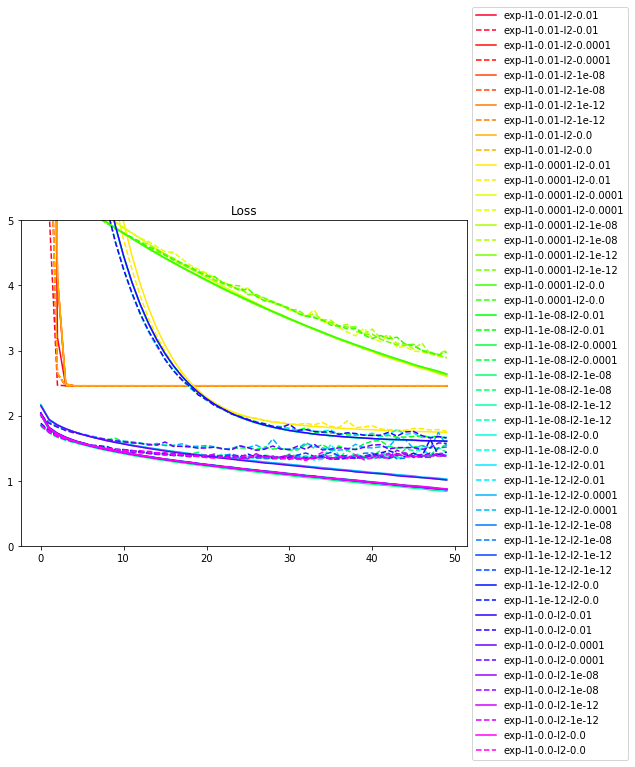

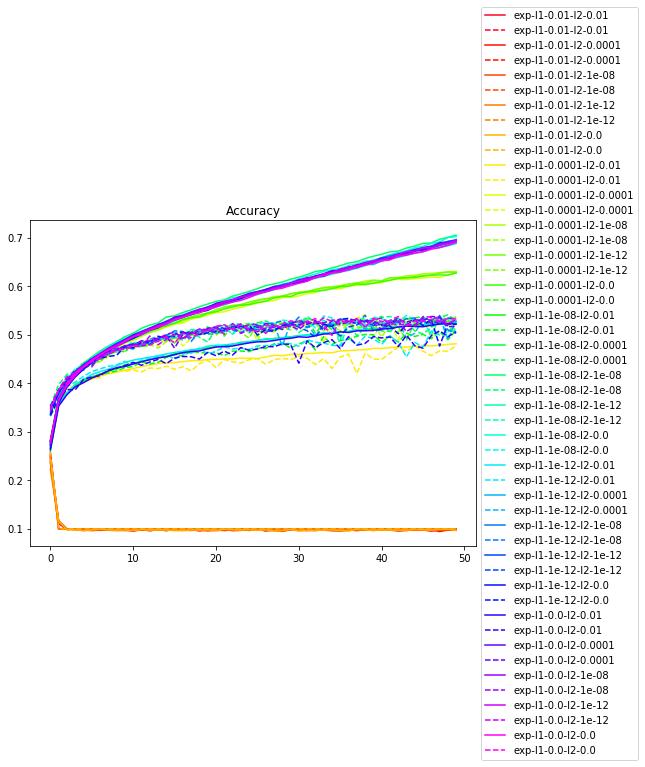

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [18]:
from keras.regularizers import l1
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

import itertools
results = {}
for l1r in itertools.product(L1_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f" % (l1r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % (str(l1r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 270us/step - loss: 6.0048 - acc: 0.2739 - val_loss: 5.7999 - val_acc: 0.3517
Epoch 2/50
50000/50000 [==============================] - 12s 249us/step - loss: 5.7115 - acc: 0.3668 - val_loss: 5.6319 - val_acc: 0.3830
Epoch 3/50
50000/50000 [==============================] - 13s 253us/step - loss: 5.5643 - acc: 0.3970 - val_loss: 5.4986 - val_acc: 0.4102
Epoch 4/50
50000/50000 [==============================] - 12s 246us/step - loss: 5.4443 - acc: 0.4168 - val_loss: 5.3891 - val_acc: 0.4244
Epoch 5/50
50000/50000 [==============================] - 12s 249us/step - loss: 5.3352 - acc: 0.4325 - val_loss: 5.2886 - val_acc: 0.4362
Epoch 6/50
50000/50000 [==============================] - 12s 244us/step - loss: 5.2355 - acc: 0.4477 - val_loss: 5.1974 - val_acc: 0.4480
Epoch 7/50
50000/50000 [==============================] - 13s 251us/step - loss: 5.1421 - acc: 0.4571 - val_loss: 5.

50000/50000 [==============================] - 22s 432us/step - loss: 2.0401 - acc: 0.2709 - val_loss: 1.8738 - val_acc: 0.3412
Epoch 2/50
50000/50000 [==============================] - 19s 377us/step - loss: 1.8129 - acc: 0.3648 - val_loss: 1.7674 - val_acc: 0.3789
Epoch 3/50
50000/50000 [==============================] - 19s 384us/step - loss: 1.7247 - acc: 0.3946 - val_loss: 1.6871 - val_acc: 0.4088
Epoch 4/50
50000/50000 [==============================] - 19s 379us/step - loss: 1.6633 - acc: 0.4167 - val_loss: 1.6471 - val_acc: 0.4178
Epoch 5/50
50000/50000 [==============================] - 19s 375us/step - loss: 1.6144 - acc: 0.4342 - val_loss: 1.6114 - val_acc: 0.4283
Epoch 6/50
50000/50000 [==============================] - 19s 376us/step - loss: 1.5753 - acc: 0.4488 - val_loss: 1.5687 - val_acc: 0.4440
Epoch 7/50
50000/50000 [==============================] - 19s 381us/step - loss: 1.5402 - acc: 0.4597 - val_loss: 1.5474 - val_acc: 0.4547
Epoch 8/50
50000/50000 [==============

Epoch 20/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.2636 - acc: 0.5565 - val_loss: 1.3917 - val_acc: 0.5101
Epoch 21/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.2489 - acc: 0.5614 - val_loss: 1.3660 - val_acc: 0.5163
Epoch 22/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.2303 - acc: 0.5685 - val_loss: 1.3802 - val_acc: 0.5112
Epoch 23/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.2169 - acc: 0.5716 - val_loss: 1.4414 - val_acc: 0.4900
Epoch 24/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.1319 - acc: 0.6044 - val_loss: 1.3497 - val_acc: 0.5234
Epoch 30/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.1188 - acc: 0.6065 - val_loss: 1.3359 - val_acc: 0.5282
Epoch 31/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.1080 - acc: 0.6108 - val_loss: 1.3470 - val_acc: 0.5262
Epoch 32/50
50000/50

Epoch 41/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.9778 - acc: 0.6577 - val_loss: 1.3859 - val_acc: 0.5218
Epoch 42/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.9610 - acc: 0.6640 - val_loss: 1.4547 - val_acc: 0.5056
Epoch 43/50
50000/50000 [==============================] - 11s 219us/step - loss: 0.9517 - acc: 0.6652 - val_loss: 1.3636 - val_acc: 0.5256
Epoch 44/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.9331 - acc: 0.6731 - val_loss: 1.4582 - val_acc: 0.5034
Epoch 45/50
50000/50000 [==============================] - 12s 241us/step - loss: 0.9256 - acc: 0.6728 - val_loss: 1.4138 - val_acc: 0.5250
Epoch 46/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.9171 - acc: 0.6791 - val_loss: 1.4624 - val_acc: 0.5162
Epoch 47/50
50000/50000 [==============================] - 13s 260us/step - loss: 0.8989 - acc: 0.6860 - val_loss: 1.4275 - val_acc: 0.5113
Epoch 48/50
50000/50

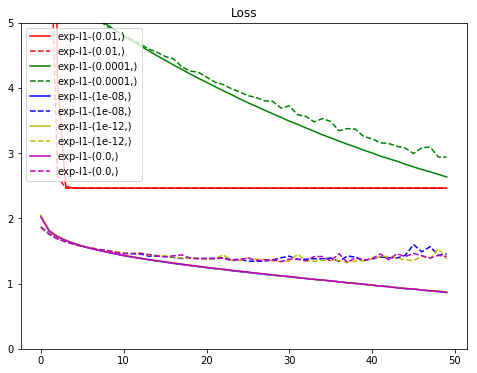

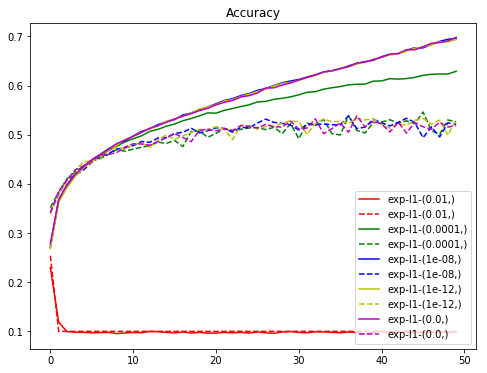

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()